In [1]:
from mlxtend.data import loadlocal_mnist
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
import pickle
import os
%matplotlib inline
np.random.seed(1)

### 1. Get Data

In [2]:
def load_dataset():
    X_train, y_train = loadlocal_mnist(
        images_path='/Users/dibu/Gatech Academics/BigDataSystems-CS6220/BigDataAssignments/Assignment1/workspace/MNIST_dataset/train-images-idx3-ubyte', 
        labels_path='/Users/dibu/Gatech Academics/BigDataSystems-CS6220/BigDataAssignments/Assignment1/workspace/MNIST_dataset/train-labels-idx1-ubyte')
    
    X_test, y_test = loadlocal_mnist(
        images_path='/Users/dibu/Gatech Academics/BigDataSystems-CS6220/BigDataAssignments/Assignment1/workspace/MNIST_dataset/t10k-images-idx3-ubyte', 
        labels_path='/Users/dibu/Gatech Academics/BigDataSystems-CS6220/BigDataAssignments/Assignment1/workspace/MNIST_dataset/t10k-labels-idx1-ubyte')
    
    X_train = X_train.reshape(60000,28,28)
    X_test = X_test.reshape(10000,28,28)
    return X_train, y_train, X_test, y_test

In [3]:
def load_outlier_data():
    num_classes = 40
    rootDir = '/Users/dibu/Gatech Academics/BigDataSystems-CS6220/BigDataAssignments/Assignment1/workspace/OutlierTestData/MNSIT'
    X=[]
    flag = 0
    basedir = ""
    
    for dirName, subdirList, fileList in os.walk(rootDir):
        for fname in fileList:
            img = Image.open( dirName+'/'+fname )
            data = np.array( img, dtype='uint8' )
            X.append(data)
    
    return X

In [4]:
def convert_to_onehot(X, num_classes):
    num_classes = tf.constant(num_classes, name="num_classes")
    one_hot_matrix = tf.one_hot(X, depth= num_classes, axis= 1)
    session = tf.Session()
    X_one_hot = session.run(one_hot_matrix)
    session.close()
    return X_one_hot

(28, 28)
(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


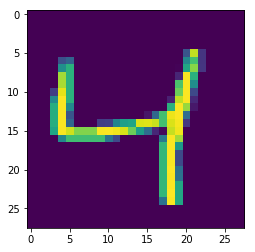

In [5]:
num_classes = 10
X_train, y_train, X_test, y_test = load_dataset()
print(X_train[0].shape)
plt.imshow(X_train[2])
y_train = convert_to_onehot(y_train, num_classes)
y_test = convert_to_onehot(y_test, num_classes)
X_train = X_train[:, :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]

# X_train = np.expand_dims(X_train, axis=1).transpose(0,2,3,1)
# X_test = np.expand_dims(X_test, axis=1).transpose(0,2,3,1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [6]:
from sys import getsizeof
getsizeof(X_train[1])
X_train.nbytes

47040000

### 2- Sample Data
(Train Data: Test Data) == (80:20)

In [7]:
sample = np.random.randint(low=0, high=60000, size=8000)
X_train_sample = X_train[sample]
Y_train_sample = y_train[sample]


sample = np.random.randint(low=0, high=10000, size=2000)
X_test_sample = X_test[sample]
Y_test_sample = y_test[sample]

print("X_train Sample shape: "+ str(X_train_sample.shape))
print("Y_train Sample shape: "+ str(Y_train_sample.shape))
print("X_test Sample shape: "+ str(X_test_sample.shape))
print("Y_test Sample shape: "+ str(Y_test_sample.shape))



X_train Sample shape: (8000, 28, 28, 1)
Y_train Sample shape: (8000, 10)
X_test Sample shape: (2000, 28, 28, 1)
Y_test Sample shape: (2000, 10)


In [8]:
X_outlier = load_outlier_data()
X_outlier = np.array(X_outlier)
X_outlier = X_outlier[:,:,:,0][:,:,:,np.newaxis]
print("X_outlier shape: "+ str(X_outlier.shape))

X_outlier shape: (10, 28, 28, 1)


### 3 -  Tensorflow Forward Pass


In [9]:
def create_placeholders(n_H0, n_W0,n_C0, n_y):
    X = tf.placeholder(tf.float32, shape=(None,n_H0,n_W0,n_C0))
    Y = tf.placeholder(tf.float32, shape=(None,n_y))
    return X, Y

### 4 - Initialize Filters


In [10]:
def initialize_parameters():
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    W1 = tf.get_variable("W1", [4,4,1,8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [2,2,8,16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

### 5- Forward Propagation


In [11]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    print(Z1.shape)
    A1 = tf.nn.relu(Z1)
    print(A1.shape)
    P1 = tf.nn.max_pool(A1, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    print(P1.shape)
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    print(Z2.shape)
    A2 = tf.nn.relu(Z2)
    print(A2.shape)
    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1], strides= [1,4,4,1], padding='SAME')
    print(P2.shape)
    P2 = tf.contrib.layers.flatten(P2)
    print(P2.shape)
    Z3 = tf.contrib.layers.fully_connected(P2, 10, activation_fn=None)
    print(Z3.shape)
    return Z3

### 6 - Compute Cost

In [12]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    return cost

### 7 - Build Model

In [13]:
def get_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    m = X.shape[0]                  
    mini_batches = []
    np.random.seed(seed)
    sample = np.random.randint(low=0, high=m, size=m)
    shuffled_X = X[sample]
    shuffled_Y = Y[sample]
    
    for k in range(0, int(m/mini_batch_size)):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[int(m/mini_batch_size) * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[int(m/mini_batch_size) * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [14]:
import time
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 100, minibatch_size = 200, print_cost = True):
    
    ops.reset_default_graph()                         
    tf.set_random_seed(1)                             
    seed = 3                                          
    (m, n_H0, n_W0,n_C0) = X_train.shape    
    n_y = Y_train.shape[1]                            
    costs = []                                        
    
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    cost = compute_cost(Z3,Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() 
    with tf.Session() as sess:
        tr_start_time = time.time()
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = get_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
            
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        save_path = saver.save(sess, "/Users/dibu/Gatech Academics/BigDataSystems-CS6220/BigDataAssignments/Assignment1/workspace/trained_models/MNIST/mnist.ckpt")
        print("Model saved in path: %s" % save_path)
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        tr_end_time = time.time()
        
        te_start_time = time.time()
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        te_end_time = time.time()
        print("Training Time: "+ str(tr_end_time - tr_start_time) + " sec")
        print("Train Accuracy:", train_accuracy)
        print("Testing Time: "+ str(te_end_time - te_start_time) + " sec")
        print("Test Accuracy:", test_accuracy)
        outlier_predictions = predict_op.eval(feed_dict={X: X_outlier})

                
        return outlier_predictions, train_accuracy, test_accuracy, parameters

### 8 - Compute Run time and Accuracy

In [15]:
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    outlier_predictions,_, _, parameters = f(*args)
    toc = time.time()
    return outlier_predictions,toc - tic

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

(?, 28, 28, 8)
(?, 28, 28, 8)
(?, 7, 7, 8)
(?, 7, 7, 16)
(?, 7, 7, 16)
(?, 2, 2, 16)
Instructions for updating:
Use keras.layers.flatten instead.
(?, 64)
(?, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 46.925565
Cost after epoch 5: 3.644225
Cost after epoch 10: 1.549406
Cost after epoch 15: 0.955937
Cost after epoch 20: 0.667752
Cost after epoch 25: 0.525563
Cost after epoch 30: 0.448444
Cost after epoch 35: 0.416789
Cost after epoch 40: 0.324094
Cost after epo

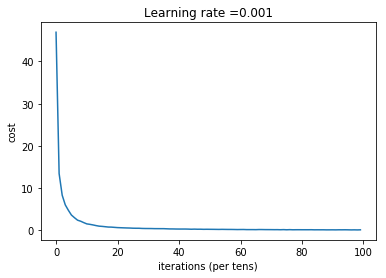

Training Time: 394.95769000053406 sec
Train Accuracy: 0.960375
Testing Time: 0.35753607749938965 sec
Test Accuracy: 0.9295


In [16]:
outlier_predictions, execution_time = time_function(model, X_train_sample, Y_train_sample, X_test_sample, Y_test_sample)

In [17]:
print("Execution Time: " + str(execution_time) + " sec")

Execution Time: 402.25962591171265 sec


### 9. Outlier Test


In [18]:
samples_per_class = 10
num_classes = 1
# for i in range(10):
#     plt_idx = i+1
#     plt.subplot(samples_per_class, num_classes, plt_idx)  
#     plt.imshow(X_outlier[i].astype('uint8'))
#     plt.axis('off')
#     i = i+1
# plt.show()

for x in np.nditer(outlier_predictions):
    print(x)

8
8
8
8
8
8
8
8
8
8
